In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../..')

In [3]:
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

In [4]:
from stack_segmentation.stack import Stack

In [5]:
from stack_segmentation.io import make_dataloader, collate_fn_basic

from stack_segmentation.training import (
    handle_stacks_data, 
    make_optimization_task, 
    train_loop
)

from stack_segmentation.pipeline_config import (
    dataloaders_conf,
    train_conf,
    model_config, 
    aug_config,
    optimizer_config,
    loss_config,
    scheduler_config,
)

In [6]:
from exp_config import data_conf

## Parameters to tune

In [7]:
train_conf['device'] = 'cuda:1'
# train_conf['device'] = 'cpu'
train_conf['num_epochs'] = 500
train_conf

{'num_epochs': 500, 'device': 'cuda:1'}

In [8]:
data_conf['conf_name'] = 'exp_basic_adamw_lr1e-3_epoch_300_resnet50_encoder_soft_aug_k_1_weight10_patch64_bs_256'
data_conf['patches'] = {
    'train': (64, 64, 1),
    'val': (64, 64, 1),
    'test': (64, 64, 1)
}
data_conf

{'conf_name': 'exp_basic_adamw_lr1e-3_epoch_300_resnet50_encoder_soft_aug_k_1_weight10_patch64_bs_256',
 'stacks': [{'path': '../../data/carb96558',
   'slice_train': (slice(None, None, None),
    slice(None, None, None),
    slice(None, 230, None)),
   'slice_val': (slice(None, None, None),
    slice(None, None, None),
    slice(250, 470, None))},
  {'path': '../../data/SoilB-2',
   'slice_train': (slice(None, None, None),
    slice(None, None, None),
    slice(None, 230, None)),
   'slice_val': (slice(None, None, None),
    slice(None, None, None),
    slice(240, 460, None))},
  {'path': '../../data/Urna_22',
   'slice_train': (slice(None, None, None),
    slice(None, None, None),
    slice(None, 220, None)),
   'slice_val': (slice(None, None, None),
    slice(None, None, None),
    slice(245, 455, None))},
  {'path': '../../data/carb96558',
   'slice_test': (slice(None, None, None),
    slice(None, None, None),
    slice(490, None, None))},
  {'path': '../../data/carb71',
   'slice_

In [9]:
model_config

{'source': 'qubvel',
 'model_type': 'Unet',
 'encoder_name': 'resnet50',
 'encoder_weights': 'imagenet'}

In [10]:
optimizer_config['opt_type'] = 'AdamW'
optimizer_config['lr'] = 1e-3
optimizer_config['weight_decay'] = 5e-5
optimizer_config['amsgrad'] = True
# optimizer_config['nesterov'] = True
optimizer_config

{'opt_type': 'AdamW',
 'lr': 0.001,
 'weight_decay': 5e-05,
 'amsgrad': True,
 'nesterov': False,
 'momentum': 0.9,
 'centered': False}

In [11]:
aug_config['aug_type'] = 'soft'
aug_config['k'] = 1
aug_config['original_height'] = 64
aug_config['original_width'] = 64
aug_config

{'aug_type': 'soft', 'original_height': 64, 'original_width': 64, 'k': 1}

In [12]:
loss_config =[
    {
        'loss': 'BCE', 
        'weight': 1, 
        'params': {'weight': [1, 10]}},
    {
        'loss': 'Dice',
        'weight': 2, 
        'params': {
            'mode': 'multiclass',
            'classes': [1], # может быть, этот параметр не нужен
            'log_loss': True,
            'from_logits': True,
            'smooth': 1,
            'eps': 1e-7
        }
    }
]
loss_config

[{'loss': 'BCE', 'weight': 1, 'params': {'weight': [1, 10]}},
 {'loss': 'Dice',
  'weight': 2,
  'params': {'mode': 'multiclass',
   'classes': [1],
   'log_loss': True,
   'from_logits': True,
   'smooth': 1,
   'eps': 1e-07}}]

In [13]:
dataloaders_conf['train']['batch_size'] = 256
dataloaders_conf['val']['batch_size'] = 256
dataloaders_conf['test']['batch_size'] = 256
dataloaders_conf

{'train': {'batch_size': 256, 'num_workers': 16, 'shuffle': True},
 'val': {'batch_size': 256, 'num_workers': 16, 'shuffle': False},
 'test': {'batch_size': 256, 'num_workers': 16, 'shuffle': True}}

## Prepare train, validation and test data

In [14]:
data_train, data_val, data_test = handle_stacks_data(**data_conf)

720it [00:01, 688.05it/s]
100%|██████████| 720/720 [00:07<00:00, 94.72it/s] 
33120it [00:00, 244432.00it/s]
31680it [00:00, 163588.87it/s]
700it [00:00, 845.57it/s]
100%|██████████| 700/700 [00:06<00:00, 101.62it/s]
27830it [00:00, 144768.93it/s]
26620it [00:00, 245503.14it/s]
710it [00:00, 853.09it/s]
100%|██████████| 710/710 [00:07<00:00, 98.65it/s] 
31680it [00:00, 141111.82it/s]
30240it [00:00, 127933.03it/s]
720it [00:00, 814.68it/s]
100%|██████████| 720/720 [00:07<00:00, 96.31it/s] 
33120it [00:00, 242946.07it/s]
720it [00:00, 828.64it/s]
100%|██████████| 720/720 [00:07<00:00, 95.76it/s] 
103680it [00:00, 174726.93it/s]
700it [00:00, 719.19it/s]
100%|██████████| 700/700 [00:06<00:00, 100.97it/s]
84700it [00:00, 225299.00it/s]
509it [00:00, 1150.88it/s]
100%|██████████| 509/509 [00:02<00:00, 194.76it/s]
32576it [00:00, 92440.64it/s]
700it [00:00, 826.33it/s]
100%|██████████| 700/700 [00:06<00:00, 100.28it/s]
84700it [00:00, 231768.05it/s]
700it [00:00, 842.12it/s]
100%|██████████|

In [15]:
len(data_train), len(data_val), len(data_test)

(92630, 88540, 11)

In [16]:
dataloader_train = make_dataloader(
    samples=data_train, 
    collate_fn=collate_fn_basic,
    model_config=model_config,
    aug_config=aug_config,
    **dataloaders_conf['train']
)

dataloader_val = make_dataloader(
    samples=data_val, 
    collate_fn=collate_fn_basic,
    model_config=model_config,
    **dataloaders_conf['val']
)

dataloaders_test = {
    name: make_dataloader(
        samples=data, 
        collate_fn=collate_fn_basic,
        model_config=model_config,
        **dataloaders_conf['test']
    ) for name, data in data_test.items()}

## Create model and metrics

In [17]:
device = 'cuda:1'
# device = 'cpu'

In [18]:
model, criterion, optimizer, scheduler = make_optimization_task(
    device,
    model_config=model_config,
    loss_config=loss_config, 
    optimizer_config=optimizer_config,
    scheduler_config=scheduler_config)

## Run experiment

In [19]:
from stack_segmentation.metrics import accuracy, precision, recall, f1, pr_auc, iou

In [20]:
metrics = {
    'accuracy': accuracy, 
    'precision': precision, 
    'recall': recall, 
    'f1': f1,
    'pr_auc': pr_auc, 
    'iou': iou,
}

In [21]:
results = train_loop(
    model=model,
    dataloader_train=dataloader_train, 
    dataloader_val=dataloader_val,
    dataloaders_test=dataloaders_test,
    criterion=criterion, 
    optimizer=optimizer, 
    scheduler=scheduler,
    metrics=metrics,
    exp_name=data_conf['conf_name'],
    **train_conf)

  0%|          | 0/362 [00:00<?, ?it/s]

Epoch 0...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.11312


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.052282
Epoch 1...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.040294


100%|██████████| 346/346 [00:30<00:00, 11.35it/s]


Mean val loss: 0.03648


  0%|          | 0/362 [00:00<?, ?it/s]

Epoch 2...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.034167


100%|██████████| 346/346 [00:30<00:00, 11.24it/s]


Mean val loss: 0.031927


  0%|          | 0/362 [00:00<?, ?it/s]

Epoch 3...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.032064


100%|██████████| 346/346 [00:30<00:00, 11.49it/s]


Mean val loss: 0.03094


  0%|          | 0/362 [00:00<?, ?it/s]

Epoch 4...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.031025


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.038334
EarlyStopping counter: 1 out of 15
Epoch 5...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.029721


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.031376
EarlyStopping counter: 2 out of 15
Epoch 6...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.029221


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.034757
EarlyStopping counter: 3 out of 15
Epoch 7...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.028401


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.047206
EarlyStopping counter: 4 out of 15
Epoch 8...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.027869


100%|██████████| 346/346 [00:30<00:00, 11.20it/s]


Mean val loss: 0.028188


  0%|          | 0/362 [00:00<?, ?it/s]

Epoch 9...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.027438


100%|██████████| 346/346 [00:30<00:00, 11.30it/s]


Mean val loss: 0.027648


  0%|          | 0/362 [00:00<?, ?it/s]

Epoch 10...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.027227


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.028108
EarlyStopping counter: 1 out of 15
Epoch 11...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.027376


100%|██████████| 346/346 [00:30<00:00, 11.30it/s]


Mean val loss: 0.027119


  0%|          | 0/362 [00:00<?, ?it/s]

Epoch 12...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.026742


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.030149
EarlyStopping counter: 1 out of 15
Epoch 13...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.026441


100%|██████████| 346/346 [00:30<00:00, 11.32it/s]


Mean val loss: 0.026372


  0%|          | 0/362 [00:00<?, ?it/s]

Epoch 14...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.026282


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.028984
EarlyStopping counter: 1 out of 15
Epoch 15...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.026137


100%|██████████| 346/346 [00:30<00:00, 11.41it/s]


Mean val loss: 0.026222


  0%|          | 0/362 [00:00<?, ?it/s]

Epoch 16...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.025823


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.026992
EarlyStopping counter: 1 out of 15
Epoch 17...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.025587


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.026364
EarlyStopping counter: 2 out of 15
Epoch 18...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.02571


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.030355
EarlyStopping counter: 3 out of 15
Epoch 19...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.025381


100%|██████████| 346/346 [00:30<00:00, 11.34it/s]


Mean val loss: 0.026061


  0%|          | 0/362 [00:00<?, ?it/s]

Epoch 20...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.025125


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.031059
EarlyStopping counter: 1 out of 15
Epoch 21...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.025099


100%|██████████| 346/346 [00:30<00:00, 11.46it/s]


Mean val loss: 0.025407


  0%|          | 0/362 [00:00<?, ?it/s]

Epoch 22...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.024871


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.026788
EarlyStopping counter: 1 out of 15
Epoch 23...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.024922


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.02618
EarlyStopping counter: 2 out of 15
Epoch 24...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.024745


100%|██████████| 346/346 [00:31<00:00, 11.11it/s]


Mean val loss: 0.025209


  0%|          | 0/362 [00:00<?, ?it/s]

Epoch 25...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.0247


100%|██████████| 346/346 [00:30<00:00, 11.33it/s]


Mean val loss: 0.024906


  0%|          | 0/362 [00:00<?, ?it/s]

Epoch 26...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.024509


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.025109
EarlyStopping counter: 1 out of 15
Epoch 27...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.024379


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.030697
EarlyStopping counter: 2 out of 15
Epoch 28...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.024583


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.025075
EarlyStopping counter: 3 out of 15
Epoch 29...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.024308


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.025758
EarlyStopping counter: 4 out of 15
Epoch 30...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.024374


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.027507
EarlyStopping counter: 5 out of 15
Epoch 31...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.024002


100%|██████████| 346/346 [00:30<00:00, 11.32it/s]


Mean val loss: 0.024608


  0%|          | 0/362 [00:00<?, ?it/s]

Epoch 32...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.023961


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.024989
EarlyStopping counter: 1 out of 15
Epoch 33...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.023957


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.02486
EarlyStopping counter: 2 out of 15
Epoch 34...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.023811


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.025169
EarlyStopping counter: 3 out of 15
Epoch 35...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.023637


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.024758
EarlyStopping counter: 4 out of 15
Epoch 36...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.023857


100%|██████████| 346/346 [00:30<00:00, 11.41it/s]


Mean val loss: 0.024178


  0%|          | 0/362 [00:00<?, ?it/s]

Epoch 37...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.023566


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.024369
EarlyStopping counter: 1 out of 15
Epoch 38...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.023448


100%|██████████| 346/346 [00:31<00:00, 11.13it/s]


Mean val loss: 0.024038


  0%|          | 0/362 [00:00<?, ?it/s]

Epoch 39...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.023419


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.025777
EarlyStopping counter: 1 out of 15
Epoch 40...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.023339


100%|██████████| 346/346 [00:30<00:00, 11.31it/s]


Mean val loss: 0.023899


  0%|          | 0/362 [00:00<?, ?it/s]

Epoch 41...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.023288


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.024782
EarlyStopping counter: 1 out of 15
Epoch 42...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.023232


100%|██████████| 346/346 [00:30<00:00, 11.40it/s]


Mean val loss: 0.023894


  0%|          | 0/362 [00:00<?, ?it/s]

Epoch 43...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.023129


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.02448
EarlyStopping counter: 1 out of 15
Epoch 44...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.023112


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.024373
EarlyStopping counter: 2 out of 15
Epoch 45...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.022967


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.024557
EarlyStopping counter: 3 out of 15
Epoch 46...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.022889


100%|██████████| 346/346 [00:30<00:00, 11.34it/s]


Mean val loss: 0.023825


  0%|          | 0/362 [00:00<?, ?it/s]

Epoch 47...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.02299


100%|██████████| 346/346 [00:30<00:00, 11.39it/s]


Mean val loss: 0.023802


  0%|          | 0/362 [00:00<?, ?it/s]

Epoch 48...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.022801


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.023894
EarlyStopping counter: 1 out of 15
Epoch 49...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.022836


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.02504
EarlyStopping counter: 2 out of 15
Epoch 50...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.022687


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.024456
EarlyStopping counter: 3 out of 15
Epoch 51...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.022677


100%|██████████| 346/346 [00:30<00:00, 11.21it/s]


Mean val loss: 0.023614


  0%|          | 0/362 [00:00<?, ?it/s]

Epoch 52...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.022603


100%|██████████| 346/346 [00:30<00:00, 11.22it/s]


Mean val loss: 0.023461


  0%|          | 0/362 [00:00<?, ?it/s]

Epoch 53...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.022564


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.023778
EarlyStopping counter: 1 out of 15
Epoch 54...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.022405


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.023824
EarlyStopping counter: 2 out of 15
Epoch 55...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.022482


100%|██████████| 346/346 [00:30<00:00, 11.37it/s]


Mean val loss: 0.023312


  0%|          | 0/362 [00:00<?, ?it/s]

Epoch 56...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.022329


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.024296
EarlyStopping counter: 1 out of 15
Epoch 57...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.022369


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.02344
EarlyStopping counter: 2 out of 15
Epoch 58...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.022237


100%|██████████| 346/346 [00:30<00:00, 11.17it/s]


Mean val loss: 0.023159


  0%|          | 0/362 [00:00<?, ?it/s]

Epoch 59...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.022289


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.023523
EarlyStopping counter: 1 out of 15
Epoch 60...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.022124


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.024279
EarlyStopping counter: 2 out of 15
Epoch 61...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.022104


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.023509
EarlyStopping counter: 3 out of 15
Epoch 62...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.022101


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.023969
EarlyStopping counter: 4 out of 15
Epoch 63...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.022112


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.023188
EarlyStopping counter: 5 out of 15
Epoch 64...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.021999


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.02336
EarlyStopping counter: 6 out of 15
Epoch 65...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.022013


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.02349
EarlyStopping counter: 7 out of 15
Epoch 66...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.021912


100%|██████████| 346/346 [00:30<00:00, 11.32it/s]


Mean val loss: 0.023049


  0%|          | 0/362 [00:00<?, ?it/s]

Epoch 67...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.021867


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.023165
EarlyStopping counter: 1 out of 15
Epoch 68...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.02181


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.023267
EarlyStopping counter: 2 out of 15
Epoch 69...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.021753


100%|██████████| 346/346 [00:31<00:00, 11.12it/s]


Mean val loss: 0.023044


  0%|          | 0/362 [00:00<?, ?it/s]

Epoch 70...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.021659


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.025298
EarlyStopping counter: 1 out of 15
Epoch 71...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.021665


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.023157
EarlyStopping counter: 2 out of 15
Epoch 72...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.021621


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.023537
EarlyStopping counter: 3 out of 15
Epoch 73...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.021671


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.023489
EarlyStopping counter: 4 out of 15
Epoch 74...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.021545


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.02316
EarlyStopping counter: 5 out of 15
Epoch 75...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.02156


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.023073
EarlyStopping counter: 6 out of 15
Epoch 76...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.021668


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.023741
EarlyStopping counter: 7 out of 15
Epoch 77...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.021504


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.023579
EarlyStopping counter: 8 out of 15
Epoch 78...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.021454


100%|██████████| 346/346 [00:30<00:00, 11.25it/s]


Mean val loss: 0.023014


  0%|          | 0/362 [00:00<?, ?it/s]

Epoch 79...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.021528


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.023648
EarlyStopping counter: 1 out of 15
Epoch 80...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.021333


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.023262
EarlyStopping counter: 2 out of 15
Epoch 81...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.021329


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.024024
EarlyStopping counter: 3 out of 15
Epoch 82...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.021222


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.023256
EarlyStopping counter: 4 out of 15
Epoch 83...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.021276


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.023311
EarlyStopping counter: 5 out of 15
Epoch 84...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.021164


100%|██████████| 346/346 [00:30<00:00, 11.35it/s]


Mean val loss: 0.023008


  0%|          | 0/362 [00:00<?, ?it/s]

Epoch 85...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.021237


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.02321
EarlyStopping counter: 1 out of 15
Epoch 86...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.021191


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.023315
EarlyStopping counter: 2 out of 15
Epoch 87...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.021268


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.024456
EarlyStopping counter: 3 out of 15
Epoch 88...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.02105


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.024064
EarlyStopping counter: 4 out of 15
Epoch 89...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.021072


100%|██████████| 346/346 [00:30<00:00, 11.23it/s]


Mean val loss: 0.022899


  0%|          | 0/362 [00:00<?, ?it/s]

Epoch 90...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.021015


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.024852
EarlyStopping counter: 1 out of 15
Epoch 91...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.020993


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.023181
EarlyStopping counter: 2 out of 15
Epoch 92...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.020928


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.024322
EarlyStopping counter: 3 out of 15
Epoch 93...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.020769


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.022947
EarlyStopping counter: 4 out of 15
Epoch 94...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.020812


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.022962
EarlyStopping counter: 5 out of 15
Epoch 95...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.020821


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.023243
EarlyStopping counter: 6 out of 15
Epoch 96...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.020823


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.023152
EarlyStopping counter: 7 out of 15
Epoch 97...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.020997


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.023031
EarlyStopping counter: 8 out of 15
Epoch 98...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.020821


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.023605
EarlyStopping counter: 9 out of 15
Epoch 99...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.020805
Epoch    99: reducing learning rate of group 0 to 5.0000e-04.


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.023273
EarlyStopping counter: 10 out of 15
Epoch 100...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.020346


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.023174
EarlyStopping counter: 11 out of 15
Epoch 101...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.020251


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.023032
EarlyStopping counter: 12 out of 15
Epoch 102...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.020167


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.023198
EarlyStopping counter: 13 out of 15
Epoch 103...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.020139


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.023002
EarlyStopping counter: 14 out of 15
Epoch 104...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.020028


  0%|          | 0/130 [00:00<?, ?it/s]

Mean val loss: 0.023229
EarlyStopping counter: 15 out of 15


100%|██████████| 331/331 [07:27<00:00,  1.35s/it]


## Dump experiment results

In [22]:
import pickle
import json

In [23]:
p = './{}_exp_results.pkl'.format(data_conf['conf_name'])
with open(p, 'wb') as f:
    pickle.dump(results, f)

In [28]:
# p = './{}_exp_results.pkl'.format(data_conf['conf_name'])
# with open(p, 'rb') as f:
#     results = pickle.load(f)

In [11]:
import torch
model.load_state_dict(torch.load('./{}.pt'.format(data_conf['conf_name'])))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

## Train and validation losses

In [24]:
from itertools import chain

In [25]:
train_losses = list(chain(*[item for item in results['train_losses']]))
val_losses = list(chain(*[item for item in results['val_losses']]))

In [26]:
def moving_average(a, n=5) :
    ret = np.cumsum([a[0]] * (n - 1) + a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

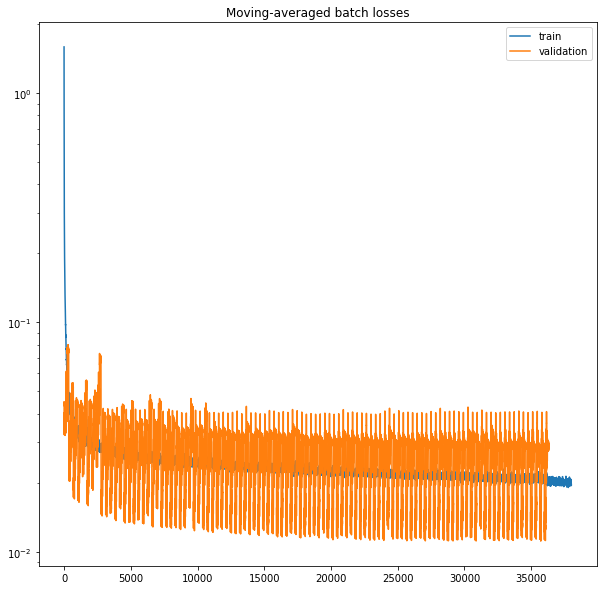

In [27]:
plt.figure(figsize=(10, 10))
plt.title('Moving-averaged batch losses')
plt.plot(np.arange(len(train_losses)), moving_average(train_losses), label='train')
plt.plot(np.arange(len(val_losses)), moving_average(val_losses), label='validation')

plt.legend(loc='best')
plt.yscale('log')

# plt.ylim([1e-2, 1])
plt.show()

In [28]:
mean_train_loss = [np.mean(item) for item in results['train_losses']]
mean_val_loss = [np.mean(item) for item in results['val_losses']]

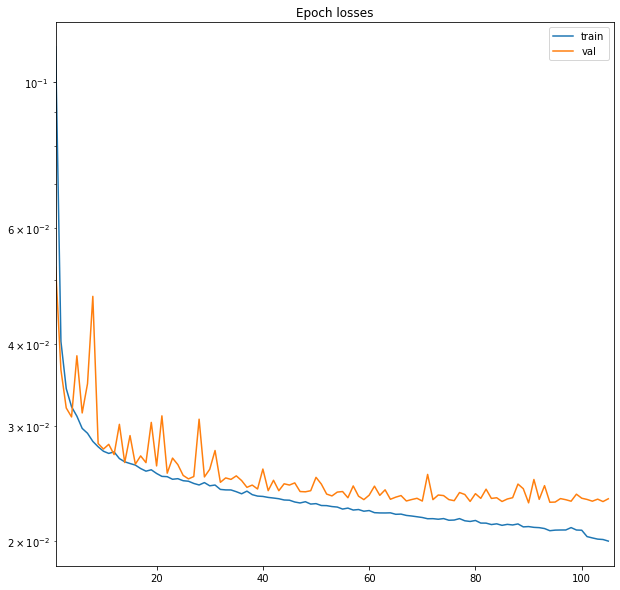

In [29]:
plt.figure(figsize=(10, 10))
plt.title('Epoch losses')
plt.plot(np.arange(len(mean_train_loss)) + 1, mean_train_loss, label='train')
plt.plot(np.arange(len(mean_val_loss)) + 1, mean_val_loss, label='val')

plt.yscale('log')
plt.legend(loc='best')

plt.xlim([1, len(mean_train_loss) + 1])
plt.show()

## Results

In [30]:
import pandas as pd

In [31]:
from visualization_utils import make_df

In [32]:
df = make_df(results, model_name='basic')
df

,accuracy,precision,recall,f1,pr_auc,iou,stack,model
0,0.996432,0.952189,0.996813,0.973990,0.998731,0.949299,carb96558,basic
1,0.985017,0.892148,0.996367,0.941382,0.984927,0.889255,carb71,basic
2,0.983339,0.915863,0.932885,0.924296,0.974860,0.859247,carbRNF,basic
3,0.994923,0.989990,0.950911,0.970057,0.996740,0.941855,SPE_carb10_58_box3,basic
4,0.991120,0.944709,0.948524,0.946613,0.991821,0.898637,SoilAh-1,basic
5,0.994222,0.917993,0.992343,0.953721,0.996940,0.911536,SoilB-2,basic
6,0.990629,0.994604,0.934808,0.963779,0.985094,0.930090,TeTree_subset1,basic
7,0.994441,0.993944,0.956814,0.975026,0.989453,0.951268,TiTree_subset2,basic
8,0.991226,0.936005,0.997031,0.965554,0.998011,0.933403,Urna_22,basic
9,0.989843,0.955442,0.988418,0.971650,0.998087,0.944864,Urna_30,basic


In [33]:
print('Mean   IOU: {:.5}'.format(df['iou'].mean()))
print('Std    IOU: {:.5}'.format(df['iou'].std()))
print('Min    IOU: {:.5}'.format(df['iou'].min()))
print('Median IOU: {:.5}'.format(df['iou'].median()))

Mean   IOU: 0.92007
Std    IOU: 0.029075
Min    IOU: 0.85925
Median IOU: 0.93009


## Check loss to loss ratio

In [34]:
criterion.losses

(WeightedLoss(
   (loss): CrossEntropyLoss()
 ), WeightedLoss(
   (loss): DiceLoss()
 ))

In [35]:
from stack_segmentation.training import make_joint_loss

In [36]:
import torch

In [37]:
# loss_config[0] = {'loss': 'BCE',
#   'weight': 0.5,
#   'params': {}}
# loss_config
# crit = make_joint_loss(device=device, loss_config=loss_config)

In [38]:
crit = criterion
a = []
b = []
for i, (x, y) in enumerate(dataloader_val):
    if i > 100:
        break
    pred = model(torch.from_numpy(x).to(device))
    y = torch.from_numpy(y).to(device)
    a.append(crit.losses[0](pred, y).cpu().data.numpy())
    b.append(crit.losses[1](pred, y).cpu().data.numpy())

In [39]:
print('Mean 0 loss: {:.4f}\nMean 1 loss: {:.4f}\nMean of ratios: {:.4f}\nRatio of means: {:.4f}'
      .format(np.mean(a), np.mean(b), np.mean(np.array(a) / np.array(b)), np.mean(a) / np.mean(b)))

Mean 0 loss: 0.0098
Mean 1 loss: 0.0042
Mean of ratios: 2.4550
Ratio of means: 2.3507
